In [1]:
#温度预测
import os
fname = os.path.join("jena_climate_2009_2016","jena_climate_2009_2016.csv")

f = open(fname)
data = f.read()
f.close()

In [2]:
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(lines)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [3]:
header

['"Date Time"',
 '"p (mbar)"',
 '"T (degC)"',
 '"Tpot (K)"',
 '"Tdew (degC)"',
 '"rh (%)"',
 '"VPmax (mbar)"',
 '"VPact (mbar)"',
 '"VPdef (mbar)"',
 '"sh (g/kg)"',
 '"H2OC (mmol/mol)"',
 '"rho (g/m**3)"',
 '"wv (m/s)"',
 '"max. wv (m/s)"',
 '"wd (deg)"']

In [4]:
#解析数据
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values


In [5]:
import matplotlib.pyplot as plt
temp = float_data[:,1]#温度

plt.plot(range(len(temp)), temp)
plt.show()

<Figure size 640x480 with 1 Axes>

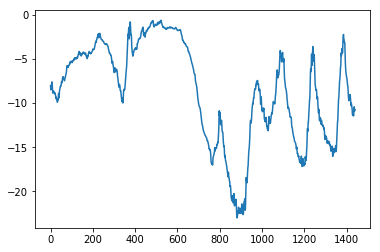

In [6]:
#绘制前10天的温度时间序列
#每10分钟记录一个数据,每天144个
plt.plot(range(1440), temp[:1440])
plt.show()

需要完成以下2件事情:
- 将数据预处理为神经网络可以处理的格式,需要对每个时间序列标准化,因为温度气压位于不同范围

- 编写python生成器,以当前的浮点数数组作为输入,并从最近的数据中生成数据批量,同时生成未来的目标温度.


In [7]:
#标准化
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std


In [8]:
# 生成时间序列样本及其目标的生成器
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128,
              step=6):
    """
    
    :param data: 浮点数数据组成的原始数组
    :param lookback: 输入数据应该包括过去多少个时间步
    :param delay: 目标应该在未来多少个时间步之后
    :param min_index: data数组中的索引,用于界定需要抽取哪些时间步/用于验证集和测试分类
    :param max_index: 同上
    :param shuffle: 打乱?
    :param batch_size: 每批样本数量
    :param step: 采样周期
    """
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback

    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))

        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets


In [9]:
#准备生成器,验证集生成器和测试集生成器
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step,
                      batch_size=batch_size)

val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)

test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

val_steps = (300000 - 200000 - lookback) // batch_size

test_steps = (len(float_data) - 300001 - lookback) // batch_size


In [10]:
##一种基于常识的,非机器学习的方法作为基准
#计算符合常识的基准方法的MAE
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, -1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))

evaluate_naive_method()

1.054366071544241


In [11]:
#将mae转换成温度误差
celsius_mae = 0.29 * std[1]
celsius_mae


2.5672247338393395

In [12]:
## 一种基本的机器学习方法
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(),loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=3,
                              validation_data=val_gen,
                              validation_steps=val_steps)



Using TensorFlow backend.


Epoch 1/20
500/500 [==============================] - 9s 17ms/step - loss: 1.4104 - val_loss: 0.6707
Epoch 2/20
500/500 [==============================] - 8s 15ms/step - loss: 0.4754 - val_loss: 0.3641
Epoch 3/20
500/500 [==============================] - 8s 15ms/step - loss: 0.3035 - val_loss: 0.3054
Epoch 4/20
500/500 [==============================] - 8s 15ms/step - loss: 0.2721 - val_loss: 0.3172
Epoch 5/20
500/500 [==============================] - 8s 15ms/step - loss: 0.2570 - val_loss: 0.3086
Epoch 6/20
500/500 [==============================] - 8s 15ms/step - loss: 0.2460 - val_loss: 0.3192
Epoch 7/20
500/500 [==============================] - 8s 15ms/step - loss: 0.2369 - val_loss: 0.3119
Epoch 8/20
500/500 [==============================] - 8s 15ms/step - loss: 0.2329 - val_loss: 0.3060
Epoch 9/20
500/500 [==============================] - 8s 15ms/step - loss: 0.2269 - val_loss: 0.3102
Epoch 10/20
500/500 [==============================] - 8s 15ms/step - loss: 0.2230 - val_lo

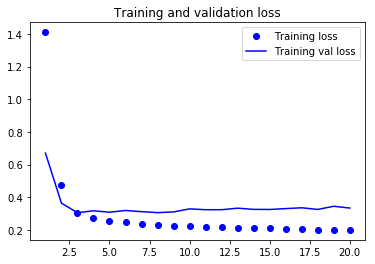

In [13]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Training val loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


In [15]:
## 第一个循环网络基准使用GRU(门控循环单元)
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')

history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=3,
                              validation_data=val_gen,
                              validation_steps=val_steps)


Epoch 1/3
500/500 [==============================] - 116s 232ms/step - loss: 0.3097 - val_loss: 0.2710
Epoch 2/3
500/500 [==============================] - 116s 231ms/step - loss: 0.2843 - val_loss: 0.2668
Epoch 3/3
500/500 [==============================] - 116s 232ms/step - loss: 0.2765 - val_loss: 0.2649


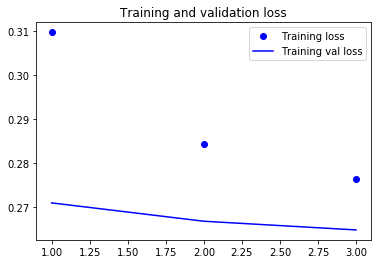

In [16]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Training val loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [21]:
##dropout正则化基于GRU模型
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, dropout=0.2,
                    recurrent_dropout=0.2,
                    input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                             steps_per_epoch=500,
                             epochs = 1,
                             validation_data = val_gen,
                             validation_steps = val_steps)

Epoch 1/1
500/500 [==============================] - 128s 257ms/step - loss: 0.3312 - val_loss: 0.2766


In [26]:
## 双向RNN训练评估一个双向LSTM
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras import  layers
from keras.models import  Sequential

max_features = 10000
maxlen = 500

(x_train,y_train),(x_test,y_test) = imdb.load_data(num_words = max_features)

x_train = [x[::-1] for x in x_train]
x_test = [x[::-1] for x in x_test]

x_train = sequence.pad_sequences(x_train,maxlen=maxlen)
x_test = sequence.pad_sequences(x_test,maxlen=maxlen)

model = Sequential()
model.add(layers.Embedding(max_features,32))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy',metrics=['acc'])
history = model.fit(x_train,y_train,
                   epochs=10,batch_size=256,
                    validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 80s 4ms/step - loss: 0.6296 - acc: 0.6549 - val_loss: 0.5633 - val_acc: 0.7256
Epoch 2/10
20000/20000 [==============================] - 81s 4ms/step - loss: 0.4364 - acc: 0.8257 - val_loss: 0.3775 - val_acc: 0.8538
Epoch 3/10
20000/20000 [==============================] - 82s 4ms/step - loss: 0.3182 - acc: 0.8795 - val_loss: 0.3073 - val_acc: 0.8852
Epoch 4/10
20000/20000 [==============================] - 82s 4ms/step - loss: 0.2670 - acc: 0.9003 - val_loss: 0.3318 - val_acc: 0.8856
Epoch 5/10
20000/20000 [==============================] - 84s 4ms/step - loss: 0.2317 - acc: 0.9163 - val_loss: 0.3287 - val_acc: 0.8874
Epoch 6/10
20000/20000 [==============================] - 81s 4ms/step - loss: 0.2082 - acc: 0.9263 - val_loss: 0.4607 - val_acc: 0.8236
Epoch 7/10
20000/20000 [==============================] - 80s 4ms/step - loss: 0.1935 - acc: 0.9303 - val_loss: 0.3495 - val_acc: